# qSeeFood Part 2

In [9]:
%matplotlib inline

# import relevant libraries
import secret
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from qiskit import IBMQ
# standard-ish Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import run_algorithm, QuantumInstance


# about transpiling, compiling, and executing
from qiskit.compiler import transpile

# For graphs
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Aer noise models
from qiskit.providers.aer import noise

# Save account if you haven't already done so
IBMQ.save_account(secret.TOKEN)

## Step 1: Finding Images
In order to do the task we first need to find images of hot dogs and not hot dogs. Thankfully, there is a kaggle dataset that had already done this for us :)

[Hot Dog Not Hot Dog](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog)


## Step 2: Processing Images
We have scaled and padded images to MNIST 28x28 size and convert to grayscale color map

In [10]:
train_hot_dog_path = os.path.join('data', 'train', 'hot_dog')
train_not_hot_dog_path = os.path.join('data', 'train', 'not_hot_dog')

test_hot_dog_path = os.path.join('data', 'test', 'hot_dog')
test_not_hot_dog_path = os.path.join('data', 'test', 'not_hot_dog')

In [54]:
train_hot_dog = []
train_not_hot_dog = []
test_hot_dog = []
test_not_hot_dog = []

def load_image(infilename) :
    # gray scale
    # img = Image.open(infilename).convert('L')
    # img.load()
    # data = np.asarray(img, dtype="int32").reshape((784))
    # color
    img = Image.open(infilename)
    data = np.asarray(img, dtype="int32").reshape((784 * 3))

    return data

for root, dirs, files in os.walk(train_hot_dog_path):
    for name in files:
        im_path = os.path.join(root, name)
        if im_path[-3:] == 'jpg':
            train_hot_dog.append(load_image(im_path))
            
for root, dirs, files in os.walk(train_not_hot_dog_path):
    for name in files:
        im_path = os.path.join(root, name)
        if im_path[-3:] == 'jpg':
            train_not_hot_dog.append(load_image(im_path))
            
for root, dirs, files in os.walk(test_hot_dog_path):
    for name in files:
        im_path = os.path.join(root, name)
        if im_path[-3:] == 'jpg':
            test_hot_dog.append(load_image(im_path))
            
for root, dirs, files in os.walk(test_not_hot_dog_path):
    for name in files:
        im_path = os.path.join(root, name)
        if im_path[-3:] == 'jpg':
            test_not_hot_dog.append(load_image(im_path))

[0 6 0 ... 1 0 2]


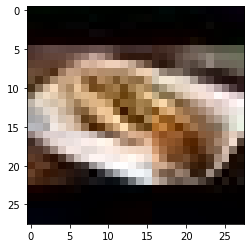

In [56]:
# sanity check
print(train_hot_dog[0])
plt.imshow(train_hot_dog[0].reshape(28,28, 3))

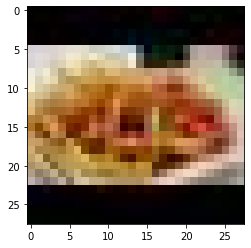

In [59]:
plt.imshow(train_not_hot_dog[0].reshape(28, 28, 3))

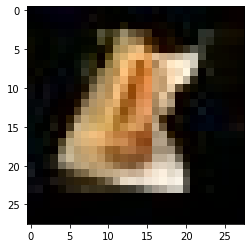

In [58]:
plt.imshow(test_hot_dog[0].reshape(28, 28, 3))

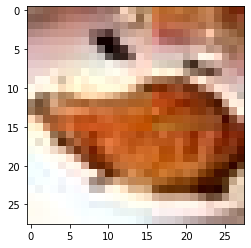

In [57]:
plt.imshow(test_not_hot_dog[0].reshape(28, 28, 3))

# QSVM on Hot Dogs and Not Hot Dogs

In [60]:
train_0_new = np.array(train_hot_dog)
train_1_new = np.array(train_not_hot_dog)

test_0_new = np.array(test_hot_dog)
test_1_new = np.array(test_not_hot_dog)

# Scale images
scaler = StandardScaler()
scaler.fit(train_0_new)
train_0_new = scaler.transform(train_0_new)
train_1_new = scaler.transform(train_1_new)
test_0_new = scaler.transform(test_0_new)
test_1_new = scaler.transform(test_1_new)

In [61]:
all_results = {}

n_components = 3
n_depth = 3

pca = PCA(n_components=n_components)
pca.fit(train_0_new)
train_0_pca = pca.transform(train_0_new)
train_1_pca = pca.transform(train_1_new)
test_0_pca = pca.transform(test_0_new)
test_1_pca = pca.transform(test_1_new)

training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024


train_0_final = train_0_pca[:training_dataset_size]
train_1_final = train_1_pca[:training_dataset_size]

test_0_final = test_0_pca[:testing_dataset_size]
test_1_final = test_1_pca[:testing_dataset_size]

train_dataset = {'0': train_0_final, 
                 '1': train_1_final}

test_dataset = {'0': test_0_final, 
                '1': test_1_final}

class_name = {'0': 0, '1': 1}

train_datapoints, class_to_label_train = split_dataset_to_data_and_labels(train_dataset, class_name)
test_datapoints, class_to_label_test = split_dataset_to_data_and_labels(test_dataset, class_name)

#         print(class_to_label_train)
#         print(class_to_label_test)

# backend = IBMQ.backend('qasm_simulator')             
backend = Aer.get_backend('qasm_simulator')

feature_map = SecondOrderExpansion(n_components, depth=n_depth)
svm = QSVM(feature_map, train_dataset, test_dataset, None)# the data for prediction can be feeded later.
svm.random_seed = random_seed
quantum_instance = QuantumInstance(backend, shots=shots)
result = svm.run(quantum_instance)

# print("n_components: {}, n_depth: {}".format(3, ))
# print(result['testing_accuracy'])
# all_results[(n_components, n_depth)] = result

In [62]:
print(result['testing_accuracy'])

0.55


In [ ]:
svm